# Libraries

In [124]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.cluster import KMeans

from nltk.corpus import stopwords 
import string
from textblob import TextBlob

# Data

In [125]:
#import data on cities and attractions
df = pd.read_csv('Data.csv')

# Data Cleaning

In [126]:
#fix column names
#description -> desc
#reviewers -> revs
#tcity15cd -> towncity_id
#attraction -> attr
df.columns = df.columns.str.lower().str.replace('tcity15cd', 'towncity_id').str.replace('attraction', 'attr').str.replace('description', 'desc').str.replace('reviewers', 'revs').str.replace(' ', '_')

In [127]:
#drop null rows
df.drop(axis = 0, index = [109, 110, 111], inplace = True)

In [128]:
#removing trailing white space from town/city 
df['town/city'] = [x.rstrip() for x in df['town/city']]

In [129]:
#fill missing values in reviews
#df[['revs_1', 'revs_2', 'revs_3', 'revs_4', 'revs_5', 'revs_6', 'revs_7', 'revs_8', 'revs_9']] = df[['revs_1', 'revs_2', 'revs_3', 'revs_4', 'revs_5', 'revs_6', 'revs_7', 'revs_8', 'revs_9']].fillna(0)

#change review data type to int
#df[['revs_1', 'revs_2', 'revs_3', 'revs_4', 'revs_5', 'revs_6', 'revs_7', 'revs_8', 'revs_9']] = df[['revs_1', 'revs_2', 'revs_3', 'revs_4', 'revs_5', 'revs_6', 'revs_7', 'revs_8', 'revs_9']].astype('int64')

#create total reviews column
#df['total_revs'] = df.revs_1 + df.revs_2 + df.revs_3 + df.revs_4 + df.revs_5 + df.revs_6 + df.revs_7 + df.revs_7 + df.revs_9

In [130]:
#drop review columns since they will not be used
df.drop(columns = ['revs_1', 'revs_2', 'revs_3', 'revs_4', 'revs_5', 'revs_6', 'revs_7', 'revs_8', 'revs_9'], inplace=True)

#drop ratings columns since they will not be used
df.drop(columns = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9'], inplace=True)

In [131]:
#fix naming error
df.rename(columns = {'attr_6.1':'attr_7'}, inplace = True)

In [132]:
#set data type to string so the function will concat
df[['attr_1', 'desc_1', 'attr_2', 'desc_2', 'attr_3', 'desc_3', 'attr_4', 'desc_4', 'attr_5', 'desc_5', 'attr_6', 'desc_6', 'attr_7', 'desc_7', 'attr_8', 'desc_8', 'attr_9', 'desc_9']] = df[['attr_1', 'desc_1', 'attr_2', 'desc_2', 'attr_3', 'desc_3', 'attr_4', 'desc_4', 'attr_5', 'desc_5', 'attr_6', 'desc_6', 'attr_7', 'desc_7', 'attr_8', 'desc_8', 'attr_9', 'desc_9']].astype('str')

In [133]:
#change tags data type to string
df.tags = df.tags.astype('str')

In [134]:
#replace nulls in the descriptions and attractions
df[['attr_1', 'desc_1', 'attr_2', 'desc_2', 'attr_3', 'desc_3', 'attr_4', 'desc_4', 'attr_5', 'desc_5', 'attr_6', 'desc_6', 'attr_7', 'desc_7', 'attr_8', 'desc_8', 'attr_9', 'desc_9']] = df[['attr_1', 'desc_1', 'attr_2', 'desc_2', 'attr_3', 'desc_3', 'attr_4', 'desc_4', 'attr_5', 'desc_5', 'attr_6', 'desc_6', 'attr_7', 'desc_7', 'attr_8', 'desc_8', 'attr_9', 'desc_9']].fillna('none')

In [135]:
#check that columns are correctly labeled and only wanted columns remain
df.columns

Index(['towncity_id', 'town/city', 'region/country', 'attr_1', 'desc_1',
       'attr_2', 'desc_2', 'attr_3', 'desc_3', 'attr_4', 'desc_4', 'attr_5',
       'desc_5', 'attr_6', 'desc_6', 'attr_7', 'desc_7', 'attr_8', 'desc_8',
       'attr_9', 'desc_9', 'tags'],
      dtype='object')

In [136]:
#check that all nulls have been filled 
df.isnull().sum()

towncity_id       0
town/city         0
region/country    0
attr_1            0
desc_1            0
attr_2            0
desc_2            0
attr_3            0
desc_3            0
attr_4            0
desc_4            0
attr_5            0
desc_5            0
attr_6            0
desc_6            0
attr_7            0
desc_7            0
attr_8            0
desc_8            0
attr_9            0
desc_9            0
tags              0
dtype: int64

# Data Preparation

In [137]:
#create simple id column for use in model
df['simple_id'] = range(1,110)

In [138]:
#create stopwords to be used in Count Vectorizer
stpwrd = stopwords.words('english')
stpwrd.extend(['none', "'s", 's'])
stpwrd.extend(string.punctuation)

In [139]:
# create keywords function
def get_keywords(df):
    '''Concats the strings from the attraction columns to form a list of keywords'''
    keywords = []
    for i in range(0, df.shape[0]):
        keywords.append(df['attr_1'][i] + ' ' + df['attr_2'][i] + ' ' + df['attr_3'][i] + ' ' + df['attr_4'][i] + ' ' + df['attr_5'][i] + ' ' + df['attr_6'][i] + ' ' + df['attr_7'][i] + ' ' + df['attr_8'][i] + ' ' + df['attr_9'][i] + ' ' + df['desc_1'][i] + ' ' + df['desc_2'][i] + ' ' + df['desc_3'][i] + ' ' + df['desc_4'][i] + ' ' + df['desc_5'][i] + ' ' + df['desc_6'][i] + ' ' + df['desc_7'][i] + ' ' + df['desc_8'][i] + ' ' + df['desc_9'][i])
    
    return keywords

In [140]:
#create keywords column for use in model
df['keywords'] = get_keywords(df)

In [141]:
#create function to modify keywords
def mod_keywords(keywords):
    '''Carries out NLP on keywords to normalise them'''
    keys = TextBlob(keywords)
    keys = keys.lower()
    keys = keys.words
    keys = keys.lemmatize()
    
    keys = ' '.join(keys)
    
    return keys

In [142]:
#modify keywords
df['keywords'] = df['keywords'].apply(mod_keywords)

In [143]:
#check that key words look as expected
df.keywords.head(50)

0     calypso cove waterpark the cooper gallery lock...
1     wat tyler centre festival leisure park barley ...
2     milestone museum festival place willis musuem ...
3     the roman bath bath abbey thermae bath spa pul...
4     zsl whipsnade zoo woburn safari park wrest par...
5     royal albert dock liverpool tate liverpool the...
6     birmingham museum art gallery cadbury world bl...
7     blackburn museum art gallery witton country pa...
8     blackpool pleasure beach blackpool zoo sandcas...
9     rivington pike bolton museum art gallery aquar...
10    brownsea island old harry rock hengistbury hea...
11    coral reef bracknell 's waterworld south hill ...
12    national science and medium museum brontë pars...
13    royal pavilion brighton palace pier british ai...
14    clifton suspension bridge brunel 's s great br...
15    towneley hall thompson park national trust gaw...
16    the national brewery centre claymills victoria...
17    east lancs railway bury art museum sculptu

# The Model

In [144]:
#create recommendation engine
def recommend_place(df, last_visted_place, keyword1):
    """Prints top 5 recommended towns/cities to visit in England based on the last place visted.
    Parameters
    -------------
    df: The dataframe - towns/cities, their attractions and descriptions
    last_visted_place: Last town/city visited
    keyword: Related to the type of attraction - eg. National Trust, Park, Museum, Spa
    Results
    -------------
    Top 5 recommended place to visit which have the specified keyword"""

    #accounting for whether a keyword is used
    if keyword1.lower() == 'none' or 'na' or ' ':
        rec_df = df
    else:
        rec_df = df[df['keywords'].str.contains(keyword1, case = False)]

    #.lower() to remove case sensitivity
    prev_visit = last_visted_place.lower()

    #update rec_df to include data for prev_visit if missing
    if prev_visit not in (x.lower() for x in rec_df['town/city']):
        missing_row = df[df['town/city'].str.lower() == prev_visit]
        updated_df = [rec_df, missing_row]
        rec_df = pd.concat(updated_df)

    #reset simple_id column for rec_df
    rec_df['simple_id'] = range(0, rec_df.shape[0])

    #get the id for the target place i.e. prev_visit
    target_place = rec_df[rec_df['town/city'].str.lower() == prev_visit]['simple_id'].values[0]

    #convert the text to a matrix of token counts
    keyword_matrix = CountVectorizer(stop_words = stpwrd).fit_transform(rec_df['keywords'])
    #calculate similarity
    cs = cosine_similarity(keyword_matrix)

    #list of scores for the target place
    scores = list(enumerate(cs[target_place]))
    #sort scores 
    sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
    #drop first because it would be the same as the input therefore 1
    sorted_scores = sorted_scores[1:]

    #recommendation results
    q = 0
    print(f'Top 5 recommended towns/cities based on your last visited place - {prev_visit.capitalize()}:\n -----------------------------------------------------')
    for score in sorted_scores:
        next_visit = rec_df[rec_df.simple_id == score[0]]['town/city'].values[0]
        q = q+1
        print(q, next_visit)
        if q == 5:
            break

In [145]:
recommend_place(df, 'solihull', ' ')

Top 5 recommended towns/cities based on your last visited place - Solihull:
 -----------------------------------------------------
1 Plymouth
2 Crawley
3 Coventry
4 Derby
5 Luton


# Validation

In [146]:
#create keyword matrix
keyword_matrix = CountVectorizer(stop_words = stpwrd).fit_transform(df['keywords'])

In [147]:
#calculate silhouette score and inertia to determine best number of clusters
k_range = range(2, 10)
scores = []
inertia = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=124)
    km.fit(keyword_matrix)
    scores.append(metrics.silhouette_score(keyword_matrix, km.labels_))
    inertia.append(km.inertia_)

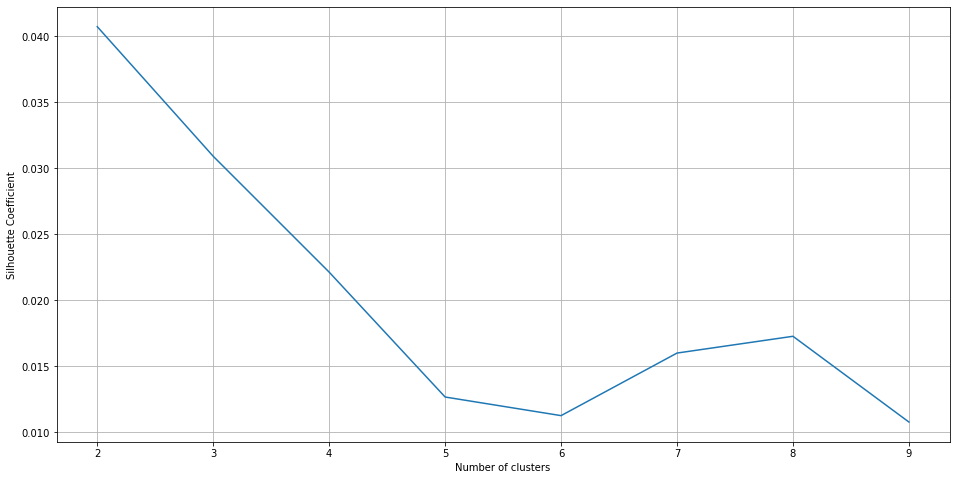

In [148]:
#visualise silhouette score
plt.figure(figsize=(16,8))
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

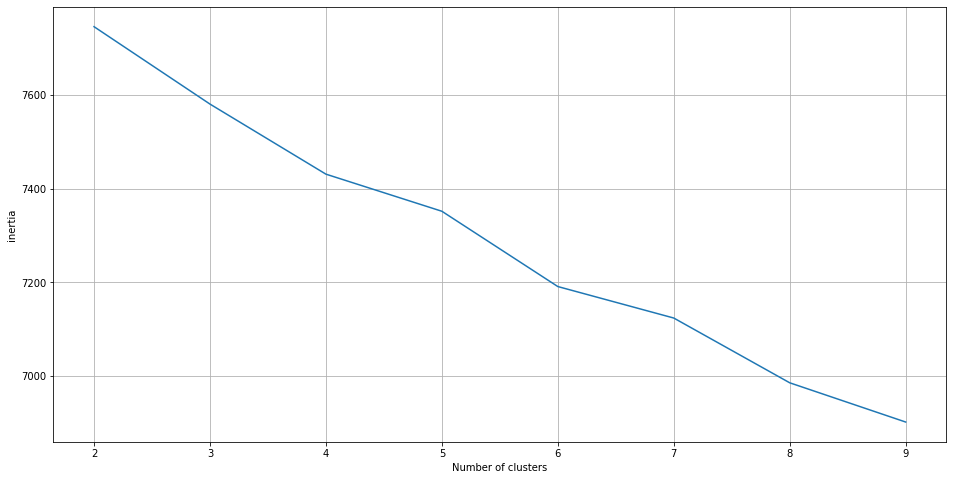

In [149]:
#visualise inertia
plt.figure(figsize=(16,8))
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.grid(True)

In [150]:
#create clusters
km = KMeans(n_clusters=3, random_state=124)
km.fit(keyword_matrix)

KMeans(n_clusters=3, random_state=124)

In [151]:
#create cluster column
df['cluster'] = km.labels_

In [152]:
#cluster labels
df.cluster.unique()

array([0, 2, 1])

In [153]:
#check cluster 0
df[df['cluster'] == 0]['town/city']

0                  Barnsley
9                    Bolton
18                Cambridge
19                 Carlisle
26                 Coventry
30                Doncaster
33                   Exeter
36               Gloucester
40                   Harlow
42               Hartlepool
43                 Hastings
49                    Leeds
50                Leicester
51                  Lincoln
61     Newcastle-under-Lyme
62              Northampton
65                 Nuneaton
67                   Oxford
72                  Preston
73                  Reading
75                 Rochdale
79                Sheffield
83            South Shields
87                St Albans
92           Stoke-on-Trent
93               Sunderland
95                  Swindon
98                  Walsall
100                 Watford
105           Wolverhampton
106               Worcester
Name: town/city, dtype: object

In [154]:
#check cluster 1
df[df['cluster'] == 1]['town/city']

3                     Bath
4                  Bedford
5               Birkenhead
6               Birmingham
12                Bradford
13       Brighton and Hove
14                 Bristol
23                 Chester
34               Gateshead
48      Kingston upon Hull
52               Liverpool
53                  London
56              Manchester
60     Newcastle upon Tyne
63                 Norwich
64              Nottingham
71              Portsmouth
84             Southampton
96                 Telford
101          West Bromwich
108                   York
Name: town/city, dtype: object

In [155]:
#check cluster 2
df[df['cluster'] == 2]['town/city']

1               Basildon
2            Basingstoke
7              Blackburn
8              Blackpool
10           Bournemouth
11             Bracknell
15               Burnley
16     Burton upon Trent
17                  Bury
20               Chatham
21            Chelmsford
22            Cheltenham
24          Chesterfield
25            Colchester
27               Crawley
28            Darlington
29                 Derby
31                Dudley
32            Eastbourne
35            Gillingham
37               Grimsby
38             Guildford
39               Halifax
41             Harrogate
44       Hemel Hempstead
45          High Wycombe
46          Huddersfield
47               Ipswich
54                 Luton
55             Maidstone
57             Mansfield
58         Middlesbrough
59         Milton Keynes
66                Oldham
68          Peterborough
69              Plymouth
70                 Poole
74              Redditch
76             Rotherham
77               Salford
